In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import sys
import tensorflow.keras
import scipy as sp
import tensorflow as tf
import platform
import numpy as np
import matplotlib.pyplot as plt
import random


import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML\

# watermark the notebook


print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")

gpus = tf.config.list_physical_devices('GPU')
print("GPU Resources Available:\n\t",gpus)

# getting rid of the warning messages about optimizer graph
# import logging
# logging.getLogger('tensorflow').setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)


# Seed control, for better reproducibility 
# NOTE: this does not gurantee results are always the same
seed = 22
random.seed(seed)
np.random.seed(seed)



EPOCHS = 100


Python Platform: Linux-5.15.0-69-generic-x86_64-with-glibc2.29
Tensor Flow Version: 2.11.0
Keras Version: 2.11.0

Python 3.8.10 (default, Mar 13 2023, 10:26:41) 
[GCC 9.4.0]
GPU Resources Available:
	 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [50]:
def make_grid(img_batches):
    batch = img_batches.shape[0]
    n_elem = round(np.sqrt(batch))
    i = 0
    j = 0
    size =  img_batches.shape[1]
    grid = np.zeros((n_elem*size,n_elem*size,3))
    for chan in range(batch):
        im = img_batches[chan,:,:,:]
        grid[i*size:(i+1)*size,j*size:(j+1)*size,:] = im.reshape((size,size,3))
        i += 1
        if i >= n_elem:
            i = 0
            j += 1
            if j >= n_elem:
                break # we are at the end of the grid capacity
    return grid

BATCH_SIZE = 256 # might try to use large batches (we will discuss why later when we talk about BigGAN)
# NOTE: the batch_size should be an integer divisor of the data set size  or torch
# will give you an error regarding batch sizes of "0" when the data loader tries to
# load in the final batch

# setup GAN dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
train_labels = tf.keras.utils.to_categorical(train_labels, 10)

BUFFER_SIZE = 60000

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 32, 32, 3)


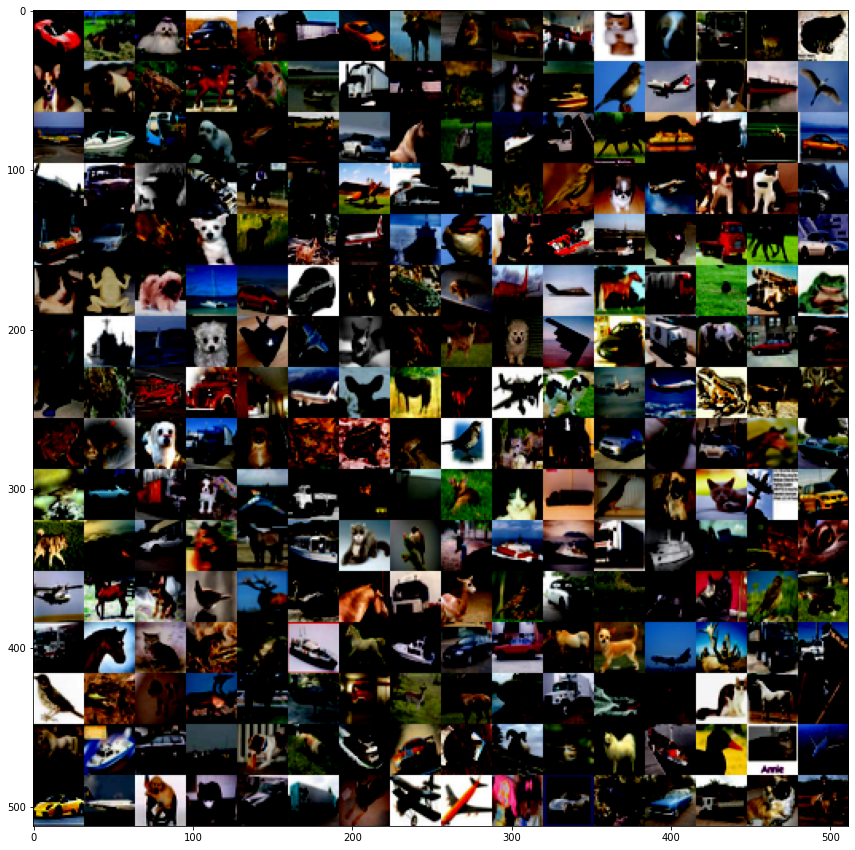

In [40]:
# get some random training images
iters = 0
for tmp in train_dataset:
    iters += 1
    
    if iters >= 1:
        break
    
tmp = tmp.numpy()
print(tmp.shape)
            
    
grid = make_grid(tmp)
# make figure large:
plt.figure(figsize=(15,15))
plt.imshow(grid)

In [86]:
from tensorflow.keras import layers
latent_dim = 100
image_size = 32
channels = 3
num_classes = 10


# this model originally from https://www.tensorflow.org/tutorials/generative/dcgan 
# manipulated to have different sizing possible
def make_generator_model():
    # assume we have a 100 dimensional sampling vector
    
    # First, transform the input into a 7x7 256-channels feature map, from latent space
    # latent space starts at 100, then upsamples for convolutio
    model = tf.keras.Sequential()
    int_size_4 = int(image_size/4)
    model.add(layers.Dense(int_size_4*int_size_4*256, use_bias=False, input_shape=(latent_dim + num_classes,), name="generator_dense_1"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # reshape to imaging for convolution
    
    model.add(layers.Reshape((int_size_4, int_size_4, 256)))
    assert model.output_shape == (None, int_size_4, int_size_4, 256)  # Note: None is the batch size

    # we will use the sequential API
    # in order to create some blocks
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, int_size_4, int_size_4, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    int_size_2 = int(image_size/2)
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, int_size_2, int_size_2, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(channels, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, image_size, image_size, channels)

    return model

In [94]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[image_size, image_size, channels + num_classes], name="discriminator_conv_1"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [95]:
# Define the output as normal GAN
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # binary cross entropy 

def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss # minimize (slides have max in them)


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img) # minimize (slides have max in them)

In [196]:
        
# Is AdaM good here? Would that improve performance? :) 
# Decay rate adjustment? 
# set discriminator learning higher than generator?
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
lambda_gp = 10

In [197]:
# This code was taken from https://keras.io/examples/generative/conditional_gan/#creating-a-conditionalgan-model
class ConditionalGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )
        with tf.GradientTape() as disc_tape:
            # Decode the noise (guided by labels) to fake images.
            generated_images = self.generator(random_vector_labels, training=True)


            # Combine them with real images. Note that we are concatenating the labels
            # with these images here.
            fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
            real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
            combined_images = tf.concat(
                [fake_image_and_labels, real_image_and_labels], axis=0
            )
            # also get interpolations for the gradient penalty
            alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
            diff = generated_images - real_images
            interpolated = real_images + alpha * diff
            interpolated = tf.concat([interpolated, image_one_hot_labels], -1)

            # Assemble labels discriminating real from fake images.
            labels = tf.concat(
                [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
            )
            fake_output = self.discriminator(fake_image_and_labels, training=True)
            real_output = self.discriminator(real_image_and_labels, training=True)
            disc_loss = discriminator_loss(real_output, fake_output)


            with tf.GradientTape(watch_accessed_variables=False) as gp_tape:
                gp_tape.watch(interpolated)

                interpolated_output = self.discriminator(interpolated, training=True)
            grads = gp_tape.gradient(interpolated_output, interpolated)
            norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
            gp = tf.reduce_mean((norm - 1.0) ** 2)
            d_loss = disc_loss + lambda_gp * gp
        variables = self.discriminator.trainable_variables
        self.d_optimizer.build(variables)
        gradients_of_discriminator = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))


        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )


        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as gen_tape:
            fake_images = self.generator(random_vector_labels, training=True)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            
            predictions = self.discriminator(fake_image_and_labels, training=True)
            
            g_loss = generator_loss(predictions)
        
        variables = self.generator.trainable_variables
        self.g_optimizer.build(variables)

        grads = gen_tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }



In [198]:
discriminator = make_discriminator_model()
generator = make_generator_model()
cond_gan = ConditionalGAN(discriminator, generator, latent_dim)

In [199]:
cond_gan.compile(d_optimizer=discriminator_optimizer, g_optimizer=generator_optimizer, loss_fn=discriminator_loss)

In [200]:
cond_gan.fit(train_dataset, epochs=200)

Epoch 1/50
train_step start
after image_one_hot_labels
after interpolations
Before setting fake and real output
right after setting fake image and labels 
train_step start
after image_one_hot_labels
after interpolations
Before setting fake and real output
right after setting fake image and labels 
196/196 [==============================] - 21s 96ms/step - g_loss: 0.6283 - d_loss: 2.5537
Epoch 2/50
196/196 [==============================] - 19s 96ms/step - g_loss: 1.2522 - d_loss: 1.4390
Epoch 3/50
196/196 [==============================] - 19s 96ms/step - g_loss: 1.4022 - d_loss: 0.8730
Epoch 4/50
196/196 [==============================] - 19s 96ms/step - g_loss: 1.6634 - d_loss: 0.7074
Epoch 5/50
196/196 [==============================] - 19s 95ms/step - g_loss: 1.2357 - d_loss: 1.0801
Epoch 6/50
196/196 [==============================] - 19s 96ms/step - g_loss: 1.3479 - d_loss: 0.8899
Epoch 7/50
196/196 [==============================] - 19s 96ms/step - g_loss: 1.1244 - d_loss: 1.099

In [249]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 9  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = tf.keras.utils.to_categorical([first_number], num_classes)
    second_label = tf.keras.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 8  # @param {type:"slider", min:0, max:9, step:1}
end_class = 8  # @param {type:"slider", min:0, max:9, step:1}

fake_images = interpolate_class(start_class, end_class)
fake_images = (fake_images * 127.5) + 127.5

1/1 [==============================] - 0s 11ms/step


In [250]:
fake_images[0]

array([[[147.28807 , 163.04324 , 169.72058 ],
        [135.8134  , 152.83313 , 157.0766  ],
        [114.84598 , 134.55693 , 146.91882 ],
        ...,
        [ 56.029175,  64.18918 ,  39.240395],
        [ 67.450226,  58.418724,  38.589485],
        [ 63.725224,  69.63135 ,  53.86032 ]],

       [[152.18549 , 164.95894 , 176.07236 ],
        [128.61603 , 148.84367 , 159.49718 ],
        [109.06073 , 122.8662  , 148.85059 ],
        ...,
        [ 59.299614,  74.49742 ,  43.709793],
        [ 51.27291 ,  55.343697,  32.720825],
        [ 50.5944  ,  60.008858,  46.027855]],

       [[150.61792 , 176.73611 , 179.0381  ],
        [141.47556 , 164.7367  , 175.05324 ],
        [123.925766, 151.05164 , 165.63974 ],
        ...,
        [ 72.11103 , 101.17834 ,  71.72302 ],
        [ 79.28412 ,  81.19034 ,  45.976677],
        [ 48.23094 ,  55.886406,  33.121033]],

       ...,

       [[140.63754 , 135.28998 , 124.06674 ],
        [144.44315 , 140.59741 , 121.69086 ],
        [134.6106  , 1

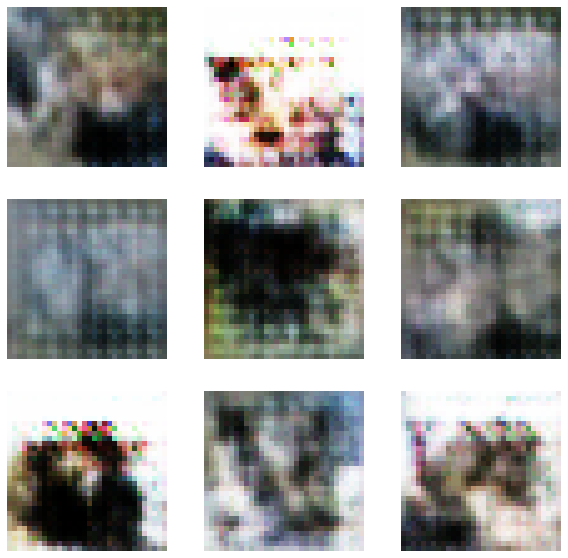

In [251]:
# plot the fake images
plt.figure(figsize=(10, 10))
for i in range(fake_images.shape[0]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(fake_images[i].astype("int32"))
    plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


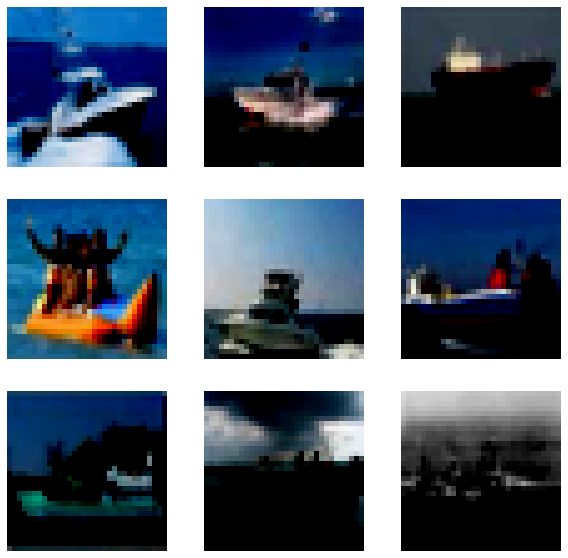

In [248]:
# plot 10 real images of class 9
plt.figure(figsize=(10, 10))
new_train_labels = np.argmax(train_labels, axis=1)
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[new_train_labels == 8][i])
    plt.axis("off")

In [223]:
fake_images

array([[[[ 0.62902087,  0.726296  ,  0.82070655],
         [ 0.870171  ,  0.8700075 ,  0.9177903 ],
         [ 0.8479937 ,  0.9108633 ,  0.95584583],
         ...,
         [ 0.14019088,  0.14731656, -0.03884332],
         [ 0.10354602,  0.12286819, -0.03308076],
         [ 0.0631542 ,  0.09046149, -0.0180472 ]],

        [[ 0.76691586,  0.8231434 ,  0.9072709 ],
         [ 0.74921715,  0.8155106 ,  0.8804519 ],
         [ 0.7783936 ,  0.84745246,  0.9461788 ],
         ...,
         [ 0.23643374,  0.19122994,  0.01109574],
         [ 0.28268144,  0.19733848,  0.02073884],
         [ 0.09677074,  0.13092867, -0.05761335]],

        [[ 0.740084  ,  0.8933309 ,  0.91425043],
         [ 0.8418351 ,  0.87548506,  0.8907643 ],
         [ 0.8456173 ,  0.89283395,  0.9266054 ],
         ...,
         [ 0.23284917,  0.18724595, -0.04815446],
         [ 0.26498637,  0.2837302 ,  0.03352851],
         [ 0.2717484 ,  0.3065496 ,  0.09452175]],

        ...,

        [[-0.8926857 , -0.8653388 , -0